In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

# Load as module

In [6]:
from TracerFit import mwfit, int_idx

In [7]:
run_id=13
size = 100000
file = "sample_iso"

model_full = mwfit(sf_bool=False, perr_bool=False)
model_full.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_full_{run_id:03d}.h')

model_sf = mwfit(sf_bool=False, perr_bool=False)
model_sf.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sfast_{run_id:03d}.h')

model_sf_perr = mwfit(sf_bool=False, perr_bool=False)
model_sf_perr.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sf_perr_{run_id:03d}.h')

# Load data

In [8]:
with h5py.File(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sf_perr_{run_id:03d}.h', 'r') as hf:
    sf_subset = hf['sf_subset'][...]

In [10]:
# Load Sample
sample = {}; true_pars={};
filename = f'/data/asfe2/Projects/mwtrace_data/mockmodel/{file}.h'
with h5py.File(filename, 'r') as hf:
    subset = np.intersect1d(hf['sample']['source_id'][...], model_full.sample['source_id'], return_indices=True)[1]
    #subset = np.arange(len(hf['sample']['source_id'][...]))
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[int_idx(key)]=hf['true_pars'][key][...]
        else:
            true_pars[int_idx(key)]={}
            for par in hf['true_pars'][key].keys():
                true_pars[int_idx(key)][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[j]['w']*=len(sample['source_id'])
    
# Apply Gaia Selection Function
# sample['gaiasf_subset'] = sf_utils.apply_gaiasf(sample['l'], np.arcsin(sample['sinb']), sample['m'])[0]

In [11]:
sample['sf_subset'] = sf_subset.copy()

In [12]:
model_full._generate_fid_pars()
model_full.sample=sample

model_sf._generate_fid_pars()
model_sf.sample=sample

model_sf_perr._generate_fid_pars()
model_sf_perr.sample=sample

Got Selectionfunction pars
Got Selectionfunction pars
Got Selectionfunction pars


In [13]:
model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'] = \
model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'][model_sf_perr.mcmc_results['lnprob']['sf_perr_mcmc'][:,1000] > 0]

# Plot results

In [13]:
true_params_f = model_full.transform_params(model_full.get_true_params(true_pars))

In [14]:
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [15]:
model_sf_perr.free_pars

{0: array(['w', 'hz', 'fD'], dtype='<U20'),
 1: array(['w', 'hz', 'fD'], dtype='<U20'),
 2: array(['w', 'hz', 'fD'], dtype='<U20'),
 'shd': array(['alpha1', 'alpha2'], dtype='<U20')}

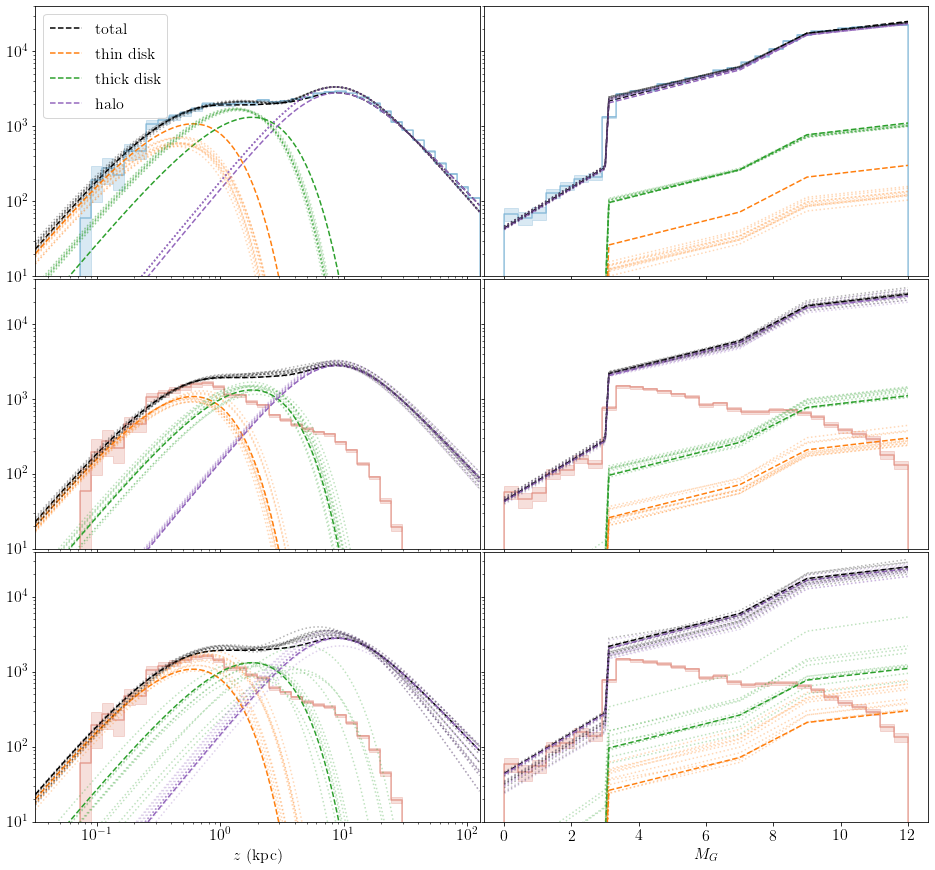

In [17]:
fig, axes = plt.subplots(3,2,figsize=(16,15), sharey=True, sharex='col')

true_parameters = true_params_f.copy()

true_kwargs = ({'c':'k','alpha':1, 'linestyle':'--', 'label':'total'}, 
               {'c':'tab:orange','alpha':1, 'linestyle':'--', 'label':'thin disk'}, 
               {'c':'tab:green','alpha':1, 'linestyle':'--', 'label':'thick disk'}, 
               {'c':'tab:purple','alpha':1, 'linestyle':'--', 'label':'halo'})

mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})


labels = ['full_mcmc', 'sf_mcmc', 'sf_perr_mcmc']
for jj, model in enumerate([model_full, model_sf, model_sf_perr]):

    nwalker, nstep, ndim = model.mcmc_results['chain'][labels[jj]].shape
    flat_chain = model.mcmc_results['chain'][labels[jj]][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.1)
    z_arr = np.logspace(zlim[0],zlim[1],101)
    axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, true_parameters, fid_pars=model.fid_pars), **true_kwargs[0])
    if jj==0:
        plotting.plot_hist(model.sample['s']*model.sample['sinb'], np.logspace(zlim[0],zlim[1],41), ax=axes[jj,0], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
    else:
        plotting.plot_hist((model.sample['s']*model.sample['sinb'])[model.sample['sf_subset']], 
                       np.logspace(zlim[0],zlim[1],41), ax=axes[jj,0], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.2), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.2),'alpha':0.2})

    components = dh_msto.z_model(z_arr, true_params_f, fid_pars=model.fid_pars, model='all')
    for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **true_kwargs[i+1]) 

    for mcmc_sample in mcmc_samples:
        axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model.fid_pars), **mcmc_kwargs[0])

        components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model.fid_pars, model='all')
        for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 

    plt.xlim(10**zlim[0],10**zlim[1])
    if jj==0: plt.legend()

    plt.sca(axes[jj,1])
    M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                              np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                        true_pars['Mms2']])))
    axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, true_parameters, fid_pars=model.fid_pars), **true_kwargs[0])
    
    if jj==0: 
        plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[jj,1], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
    else:
        plotting.plot_hist(sample['M'][sample['sf_subset']], np.linspace(0,true_pars['Mx'],30), ax=axes[jj,1], fill_poisson=True,
                      plot_kwargs={'c':cm.RdBu(0.2), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.2),'alpha':0.2})

    components = dh_msto.M_model(M_arr, true_params_f, fid_pars=model.fid_pars, model='all')
    for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **true_kwargs[i+1])

    for mcmc_sample in mcmc_samples:
        axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model.fid_pars), **mcmc_kwargs[0])

        components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model.fid_pars, model='all')
        for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 


plt.sca(axes[2,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[2,1]); plt.yscale('log'); plt.xlabel(r'$M_G$')
        
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.ylim(10.,40000)#100000000)

plt.savefig(f'figs/mock_{file}_{size}_{run_id:03d}_zM_disthist.png', bbox_inches='tight', dpi=200)

In [18]:
plt.rc('axes', labelsize=ndim*3)
plt.rc('xtick',labelsize=ndim*3)
plt.rc('ytick',labelsize=ndim*3)
plt.rc('legend',fontsize=ndim*4)
plt.rc('font',size=ndim*3)

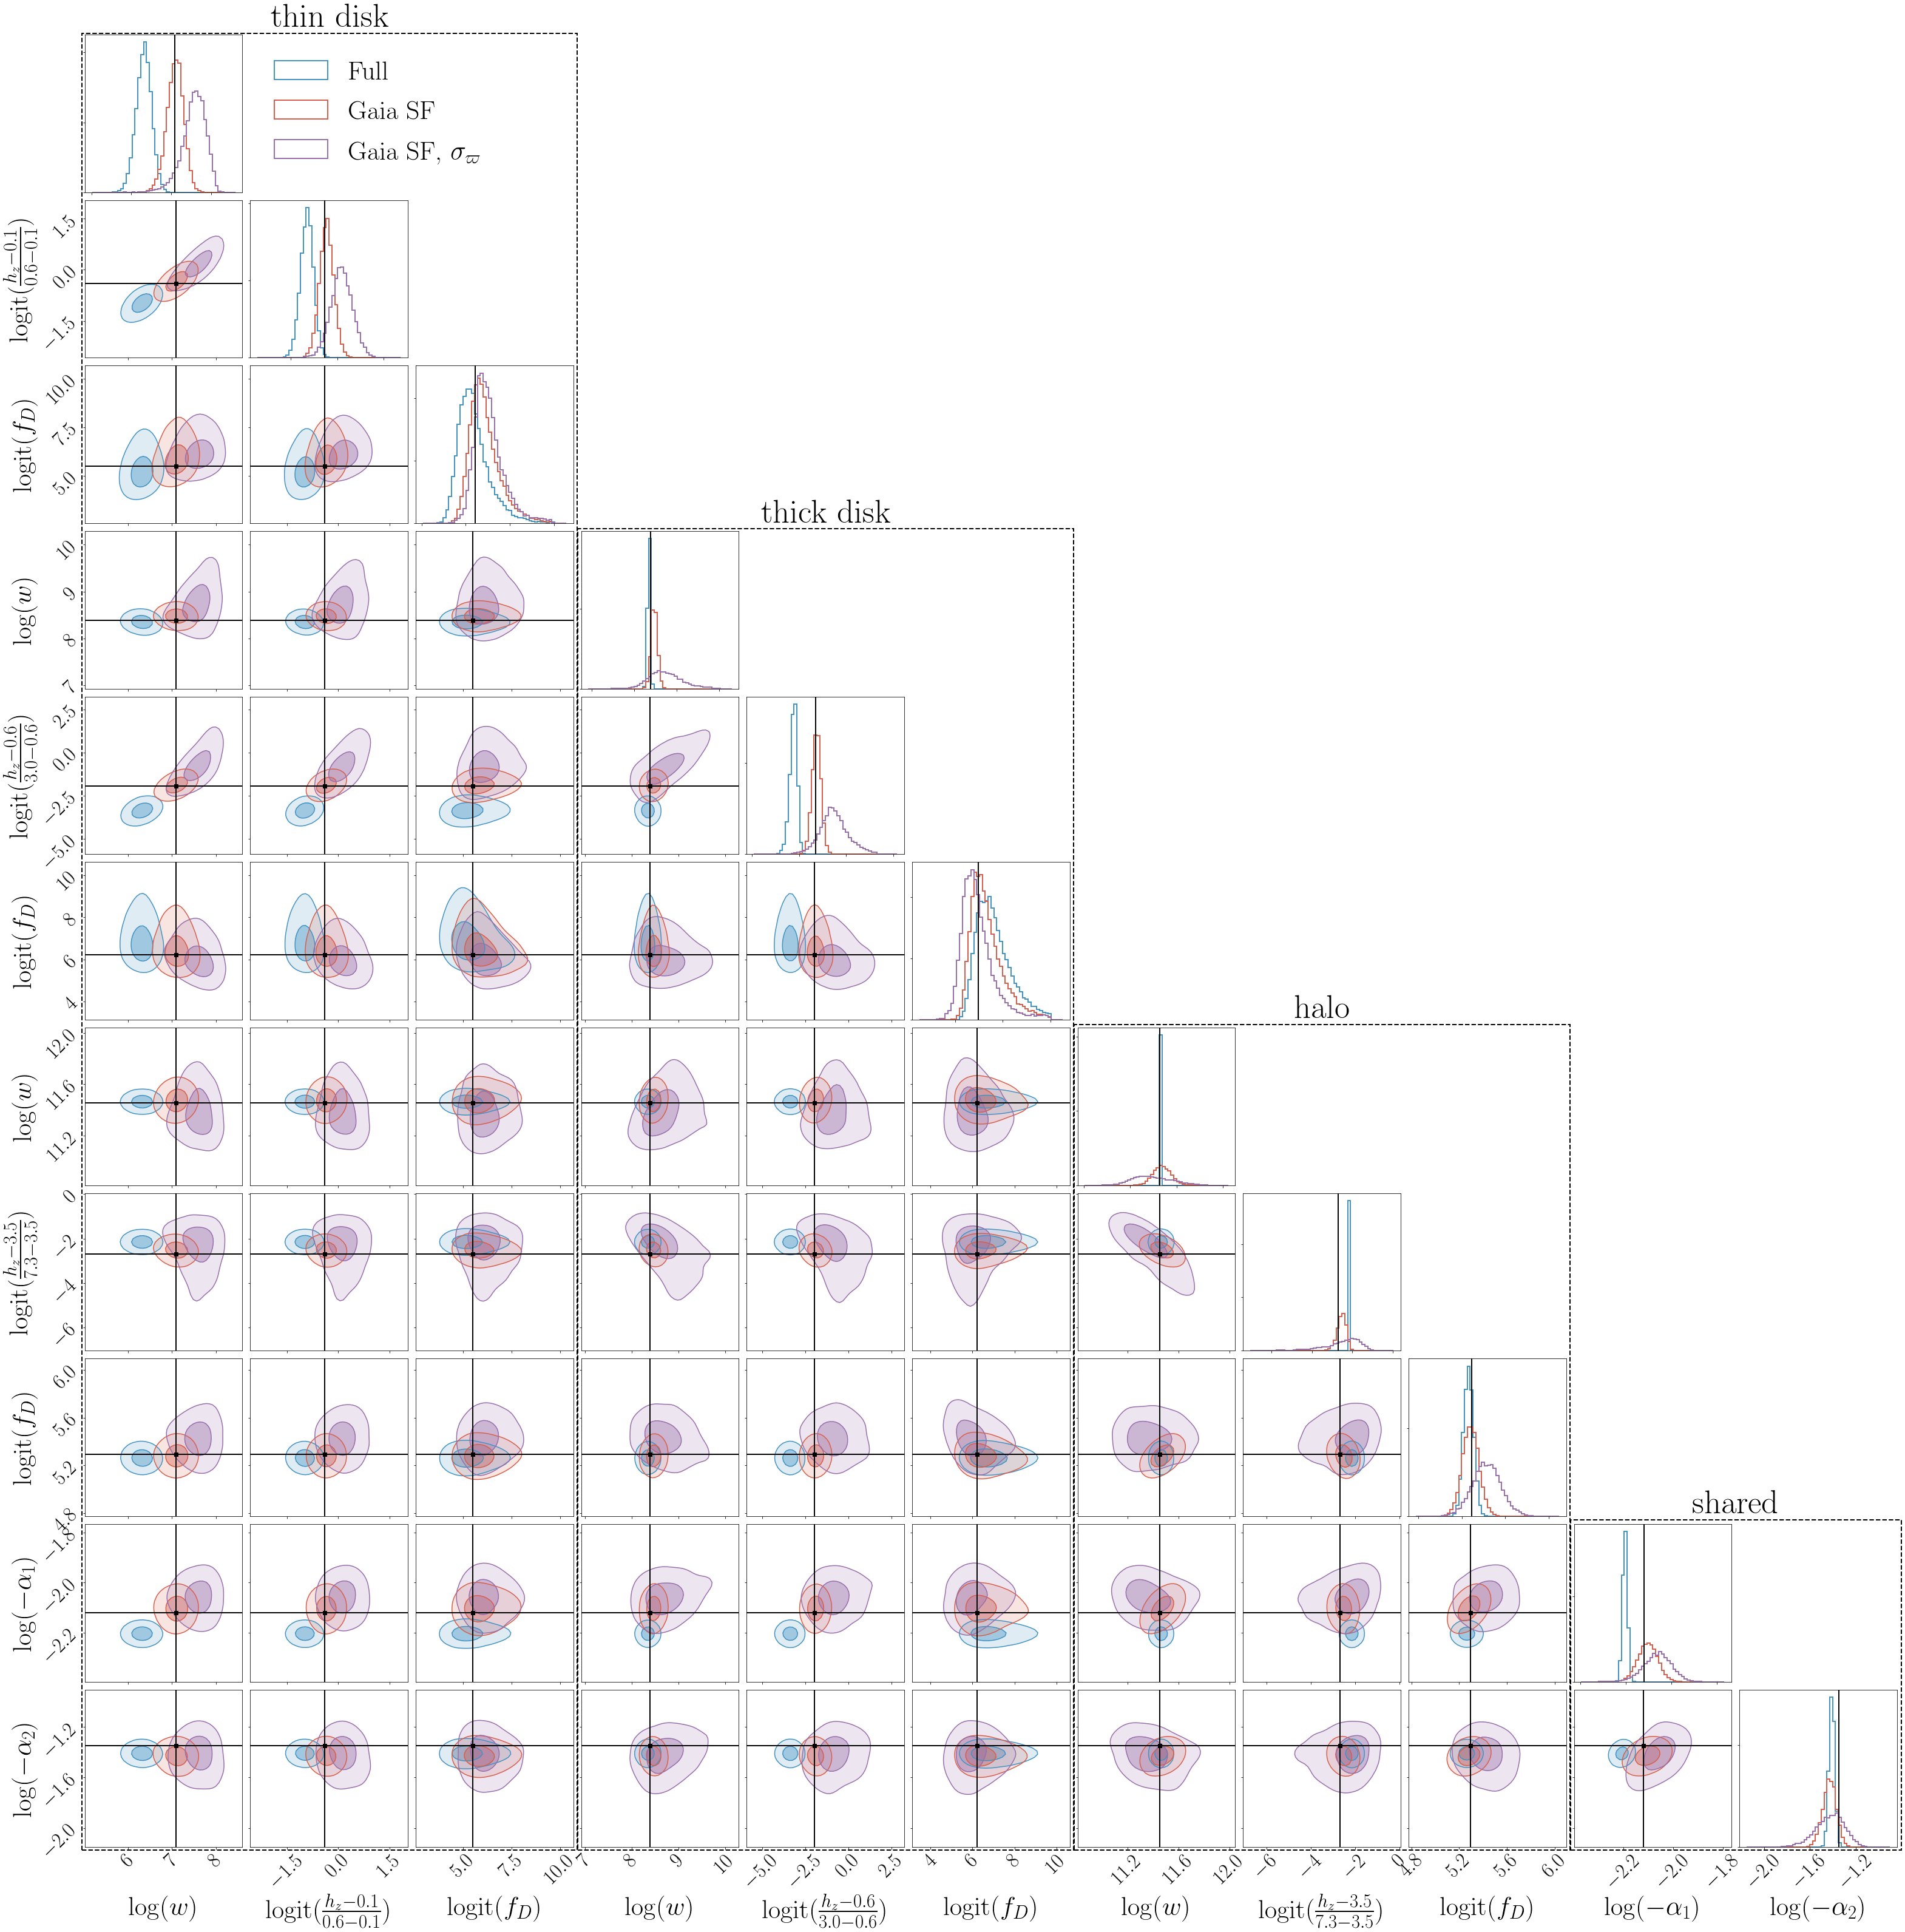

In [19]:
index = [r'Full', r'Gaia SF', r'Gaia SF, $\sigma_\varpi$']
ndim=len(true_params_f); fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))
plotting.layered_corners([model_full.mcmc_results['chain']['full_mcmc'],
                          model_sf.mcmc_results['chain']['sf_mcmc'],
                          model_sf_perr.mcmc_results['chain']['sf_perr_mcmc']], 
                         index=index, truths=true_params_f, truth_color='k',
                         hist_kwargs={'linewidth':2}, 
                         labels=model.get_labels(),
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.PRGn(0.2)], fig=fig, ax=axes,
                        label_kwargs={'fontsize':ndim*4})


npar = [len(model_full.free_pars[i]) for i in range(3)]+[len(model_full.free_pars['shd'])]
for jj, cmpt_label in enumerate(['thin disk', 'thick disk', 'halo', 'shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=5*ndim)
    #plt.text()
    
plt.savefig(f'figs/mock_{file}_{size}_{run_id:03d}_corner_f.png', bbox_inches='tight', dpi=200)

In [20]:
model_full._generate_fid_pars()
functions = [model_full.fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model_full.free_pars[j]]

labels=[];
for cmpt in np.arange(len(model_full.components)).tolist()+['shd',]:
    for par in model_full.free_pars[cmpt]:
        labels+=[label_dict[par],]

Got Selectionfunction pars


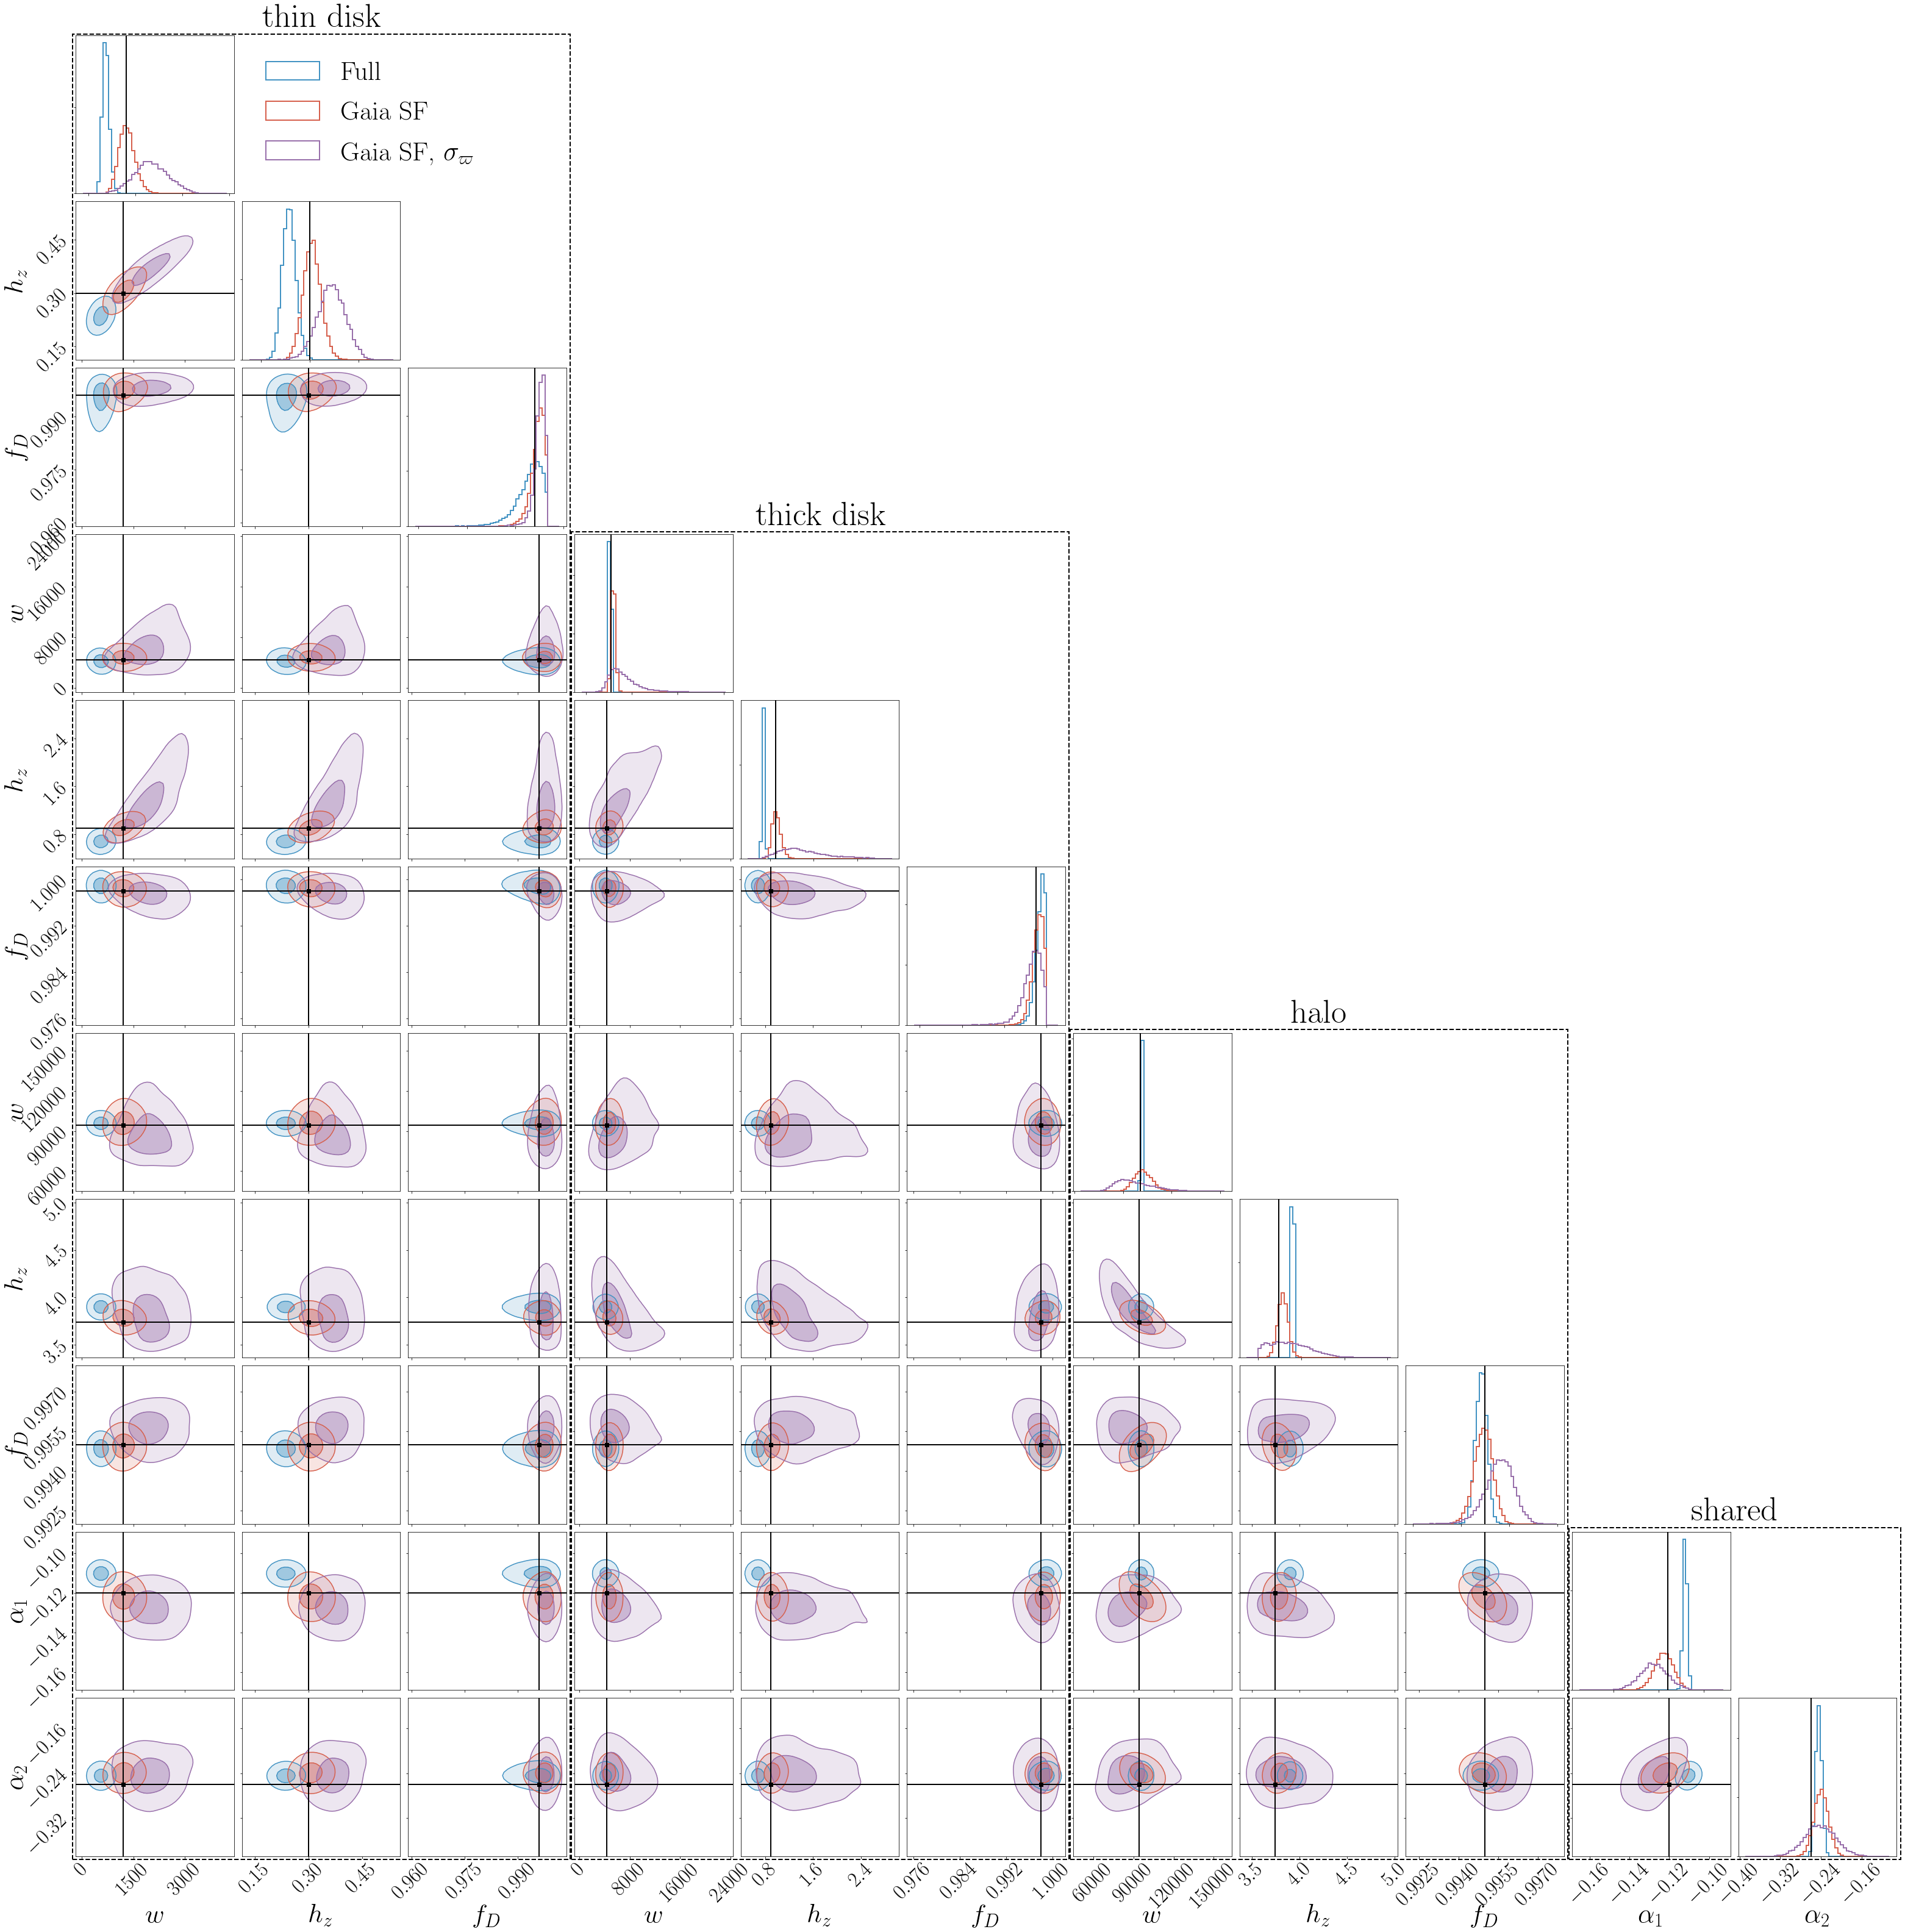

In [21]:
index = [r'Full', r'Gaia SF', r'Gaia SF, $\sigma_\varpi$']
ndim=len(true_params_f); fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))
plotting.layered_corners([model_full.mcmc_results['chain']['full_mcmc'].copy(),
                          model_sf.mcmc_results['chain']['sf_mcmc'].copy(),
                          model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'].copy()], 
                         index=index, truths=true_params_f, truth_color='k',
                         hist_kwargs={'linewidth':2}, 
                         labels=labels, functions=functions,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.PRGn(0.2)], fig=fig, ax=axes,
                        label_kwargs={'fontsize':ndim*4})


npar = [len(model_full.free_pars[i]) for i in range(3)]+[len(model_full.free_pars['shd'])]
for jj, cmpt_label in enumerate(['thin disk', 'thick disk', 'halo', 'shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=5*ndim)

plt.savefig(f'figs/mock_{file}_{size}_{run_id:03d}_corner.png', bbox_inches='tight', dpi=200)

In [22]:
true_pars

{0: {'Mto': array(3.1),
  'alpha3': array(-0.6),
  'fD': array(0.996),
  'hz': array(0.3),
  'w': array(1200.)},
 1: {'Mto': array(3.1),
  'alpha3': array(-0.73),
  'fD': array(0.998),
  'hz': array(0.9),
  'w': array(4400.)},
 2: {'Mto': array(3.1),
  'alpha3': array(-0.62),
  'fD': array(0.995),
  'hz': array(3.74),
  'w': array(94400.)},
 'Mms': array(8.),
 'Mms1': array(9.),
 'Mms2': array(7.),
 'Mx': array(12),
 'N': array(5000000),
 'R0': array(8.27),
 'alpha1': array(-0.12),
 'alpha2': array(-0.26),
 'theta_deg': array(80)}

(10.0, 40000)

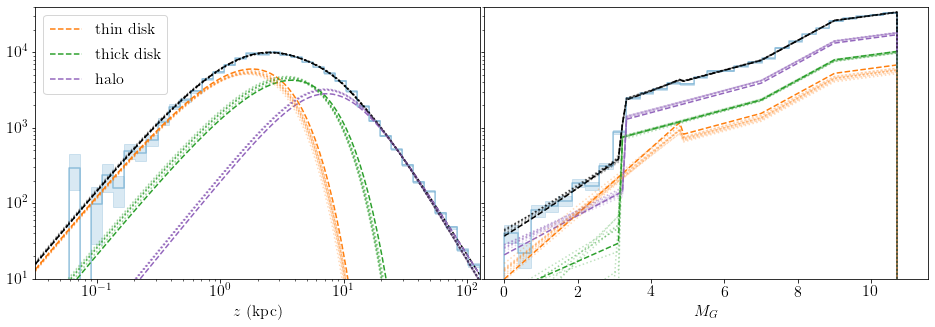

In [16]:
fig, axes = plt.subplots(1,2,figsize=(16,5), sharey=True)

parameters = true_params_f.copy()

mcmc_samples = 10
nwalker, nstep, ndim = model_full.mcmc_results['chain']['full_mcmc'].shape
flat_chain = model_full.mcmc_results['chain']['full_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

true_kwargs = ({'c':'k','alpha':1, 'linestyle':'--'}, 
               {'c':'tab:orange','alpha':1, 'linestyle':'--', 'label':'thin disk'}, 
               {'c':'tab:green','alpha':1, 'linestyle':'--', 'label':'thick disk'}, 
               {'c':'tab:purple','alpha':1, 'linestyle':'--', 'label':'halo'})

mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})

plt.sca(axes[0])
zlim = (-1.5,2.1)
z_arr = np.logspace(zlim[0],zlim[1],101)
import matplotlib.pyplot as plt
axes[0].plot(z_arr, dh_msto.z_model(z_arr, true_parameters, fid_pars=model_full.fid_pars), **true_kwargs[0])
plotting.plot_hist(model_full.sample['s']*model_full.sample['sinb'], np.logspace(zlim[0],zlim[1],41), ax=axes[0], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.xlim(0,20)

components = dh_msto.z_model(z_arr, parameters, fid_pars=model_full.fid_pars, model='all')
for i in range(3): axes[0].plot(z_arr, components[:,i], **true_kwargs[i+1]) 
    
for mcmc_sample in mcmc_samples:
    axes[0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model_full.fid_pars), **mcmc_kwargs[0])
    
    components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model_full.fid_pars, model='all')
    for i in range(3): axes[0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 
    
plt.xscale('log')
plt.xlim(10**zlim[0],10**zlim[1])
plt.legend()

plt.sca(axes[1])
M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                          np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                    true_pars['Mms2']])))
axes[1].plot(M_arr, dh_msto.M_model(M_arr, true_parameters, fid_pars=model_full.fid_pars), **true_kwargs[0])
plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[1], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})


components = dh_msto.M_model(M_arr, parameters, fid_pars=model_full.fid_pars, model='all')
for i in range(3): axes[1].plot(M_arr, components[:,i], **true_kwargs[i+1])
    
for mcmc_sample in mcmc_samples:
    axes[1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model_full.fid_pars), **mcmc_kwargs[0])
    
    components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model_full.fid_pars, model='all')
    for i in range(3): axes[1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 

plt.yscale('log'); plt.xlabel(r'$M_G$')
        
plt.subplots_adjust(wspace=0.01)

plt.ylim(10.,40000)

(10.0, 30000)

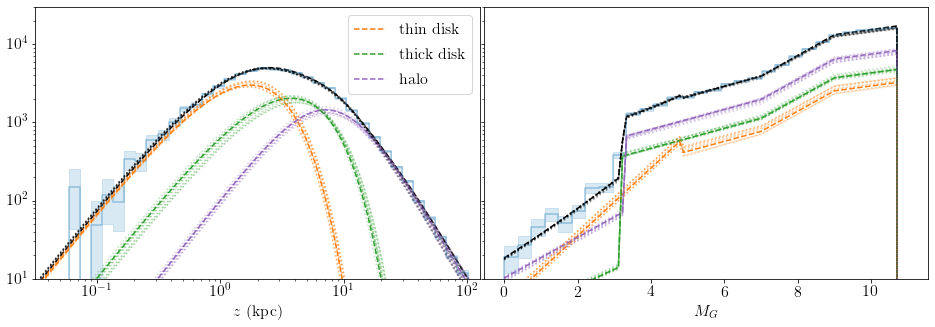

In [79]:
fig, axes = plt.subplots(1,2,figsize=(16,5), sharey=True)

true_parameters = true_params_f.copy()

mcmc_samples = 10
nwalker, nstep, ndim = model.mcmc_results['chain']['sf_mcmc'].shape
flat_chain = model.mcmc_results['chain']['sf_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

true_kwargs = ({'c':'k','alpha':1, 'linestyle':'--'}, 
               {'c':'tab:orange','alpha':1, 'linestyle':'--', 'label':'thin disk'}, 
               {'c':'tab:green','alpha':1, 'linestyle':'--', 'label':'thick disk'}, 
               {'c':'tab:purple','alpha':1, 'linestyle':'--', 'label':'halo'})

mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})

plt.sca(axes[0])
zlim = (-1.5,2.1)
z_arr = np.logspace(zlim[0],zlim[1],101)
import matplotlib.pyplot as plt
axes[0].plot(z_arr, dh_msto.z_model(z_arr, true_parameters, fid_pars=model.fid_pars), **true_kwargs[0])
plotting.plot_hist(model.sample['s']*model.sample['sinb'], np.logspace(zlim[0],zlim[1],41), ax=axes[0], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.xlim(0,20)

components = dh_msto.z_model(z_arr, parameters, fid_pars=model.fid_pars, model='all')
for i in range(3): axes[0].plot(z_arr, components[:,i], **true_kwargs[i+1]) 
    
for mcmc_sample in mcmc_samples:
    axes[0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model.fid_pars), **mcmc_kwargs[0])
    
    components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model.fid_pars, model='all')
    for i in range(3): axes[0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 
    
plt.xscale('log')
plt.xlim(10**zlim[0],10**zlim[1])
plt.legend()

plt.sca(axes[1])
M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                          np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                    true_pars['Mms2']])))
axes[1].plot(M_arr, dh_msto.M_model(M_arr, true_parameters, fid_pars=model.fid_pars), **true_kwargs[0])
plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[1], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})


components = dh_msto.M_model(M_arr, parameters, fid_pars=model.fid_pars, model='all')
for i in range(3): axes[1].plot(M_arr, components[:,i], **true_kwargs[i+1])
    
for mcmc_sample in mcmc_samples:
    axes[1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model.fid_pars), **mcmc_kwargs[0])
    
    components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model.fid_pars, model='all')
    for i in range(3): axes[1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 

plt.yscale('log'); plt.xlabel(r'$M_G$')
        
plt.subplots_adjust(wspace=0.01)

plt.ylim(10.,30000)

# Load in model fits

In [5]:
def load_hdf5_recurrent(path, hf):
    output={}

    for key in hf[path].keys():
        if isinstance(hf[os.path.join(path,key)], h5py._hl.group.Group): 
            output[int_idx(key)] = load_hdf5_recurrent(os.path.join(path,key), hf)
        else:
            output[int_idx(key)] = hf[os.path.join(path,key)][...]
            
    return output

def int_idx(i):
    if i in np.arange(10).astype(str):
        return int(i)
    else: return i

In [6]:
data = {}
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/fits_allcmpt_ncg.h'
with h5py.File(filename, 'r') as hf:
    for key in hf.keys():
        if isinstance(hf[key], h5py._hl.group.Group): 
            data[int_idx(key)] = load_hdf5_recurrent(key, hf)
        else: data[int_idx(key)] = hf[key][...]
            
for cmpt in data['param_trans'].keys():
    for par in data['param_trans'][cmpt].keys():
        data['param_trans'][cmpt][par] = data['param_trans'][cmpt][par].astype('U20').tolist()
        for i in [1,2,3,4]:
            data['param_trans'][cmpt][par][i] = float(data['param_trans'][cmpt][par][i])
for cmpt in data['free_pars'].keys():
    data['free_pars'][cmpt] = data['free_pars'][cmpt].astype('U20')

In [7]:
data.keys()

dict_keys(['fixed_pars', 'param_trans', 'lnprob', 'source_id', 'true_pars', 'free_pars', 'chain'])

# Load data

In [115]:
# Load Sample
sample = {}; true_pars={};
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample.h'
with h5py.File(filename, 'r') as hf:
    subset = np.intersect1d(hf['sample']['source_id'][...], data['source_id'], return_indices=True)[1]
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[key]=hf['true_pars'][key][...]
        else:
            true_pars[key]={}
            for par in hf['true_pars'][key].keys():
                true_pars[key][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[str(j)]['w']*=len(sample['source_id'])

In [117]:
true_params_f=[];
true_params=[]; 
for j in range(fid_pars['ncomponents']):
    for par in fid_pars['free_pars'][j]:
        true_params_f   += [fid_pars['functions_inv'][j][par](true_pars[str(j)][par]),]
        true_params += [true_pars[str(j)][par],]
for par in fid_pars['free_pars']['shd']:
    true_params_f += [fid_pars['functions_inv']['shd'][par](true_pars[par]),]
    true_params += [true_pars[par],]
true_params_f=np.array(true_params_f)
true_params=np.array(true_params)
true_params, true_params_f

(array([ 2.0e+02,  9.0e-01,  3.0e+02,  1.9e+00,  5.0e+02,  4.6e+00,
        -1.5e-01, -3.0e-01]),
 array([ 5.29831737,  0.98082925,  5.70378247, -0.45198512,  6.2146081 ,
        -0.52324814, -1.89711998, -1.2039728 ]))

In [139]:
labels=[]; params_i = 0
for cmpt in np.arange(3).tolist()+['shd',]:
    for par in data['free_pars'][cmpt]:
        labels+=[func_labels[data['param_trans'][cmpt][par][0]](label_dict[par], *data['param_trans'][cmpt][par][1:3]),]
        params_i += 1;

# Rebuild fid_pars

In [110]:
fid_pars={'Mmax':true_pars['Mx'],  'lat_min':np.deg2rad(true_pars['theta_deg']), 'R0':true_pars['R0'],
            'w':True, 'components':['disk','disk','halo'], 'ncomponents':3,
         'free_pars':data['free_pars'], 'fixed_pars':data['fixed_pars']}

In [112]:
fid_pars['functions']={}; fid_pars['functions_inv']={}; fid_pars['jacobians']={}; bounds=[]
params_i = 0
for cmpt in np.arange(fid_pars['ncomponents']).tolist()+['shd',]:
    fid_pars['functions'][cmpt]={}; fid_pars['functions_inv'][cmpt]={}; fid_pars['jacobians'][cmpt]={}
    for par in fid_pars['free_pars'][cmpt]:
        fid_pars['functions'][cmpt][par], \
        fid_pars['functions_inv'][cmpt][par], \
        fid_pars['jacobians'][cmpt][par]=func_inv_jac[data['param_trans'][cmpt][par][0]](*data['param_trans'][cmpt][par][1:3])
        bounds.append([data['param_trans'][cmpt][par][3], data['param_trans'][cmpt][par][4]])
        params_i += 1;
bounds = np.array(bounds).T

# Plot results

(0.1, 1000)

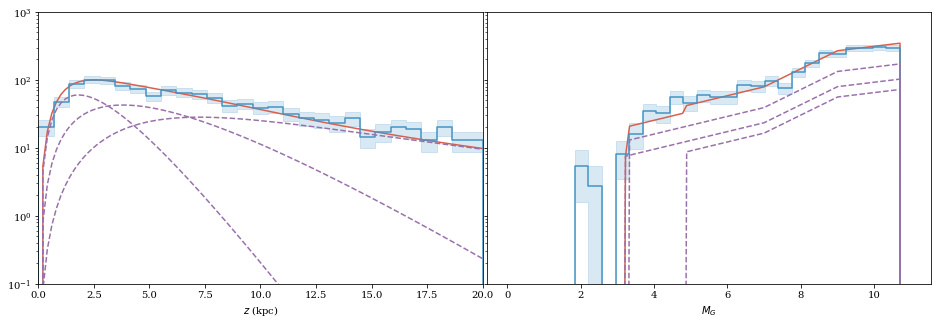

In [126]:
fig, axes = plt.subplots(1,2,figsize=(16,5), sharey=True)

plt.sca(axes[0])
z_arr = np.linspace(0,20,100)
import matplotlib.pyplot as plt
axes[0].plot(z_arr, dh_msto.z_model(z_arr, true_params_f, fid_pars=fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(sample['s']*sample['sinb'], np.linspace(0,20,30), ax=axes[0], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.xlim(0,20)

axes[0].plot(z_arr, dh_msto.z_model(z_arr, true_params_f, fid_pars=fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.sca(axes[1])
M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                          np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                    true_pars['Mms2']])))
axes[1].plot(M_arr, dh_msto.M_model(M_arr, true_params_f, fid_pars=fid_pars), c=cm.RdBu(0.2))
plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[1], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8)}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$M_G$')

axes[1].plot(M_arr, dh_msto.M_model(M_arr, true_params_f, fid_pars=fid_pars, model='all'), 
             c=cm.PRGn(0.2), linestyle='--')

plt.subplots_adjust(wspace=0.01)

plt.ylim(0.1,1000)

In [129]:
data['chain'].keys()#['full_perr']

dict_keys(['full_perr_ncg', 'full_perr', 'prior'])

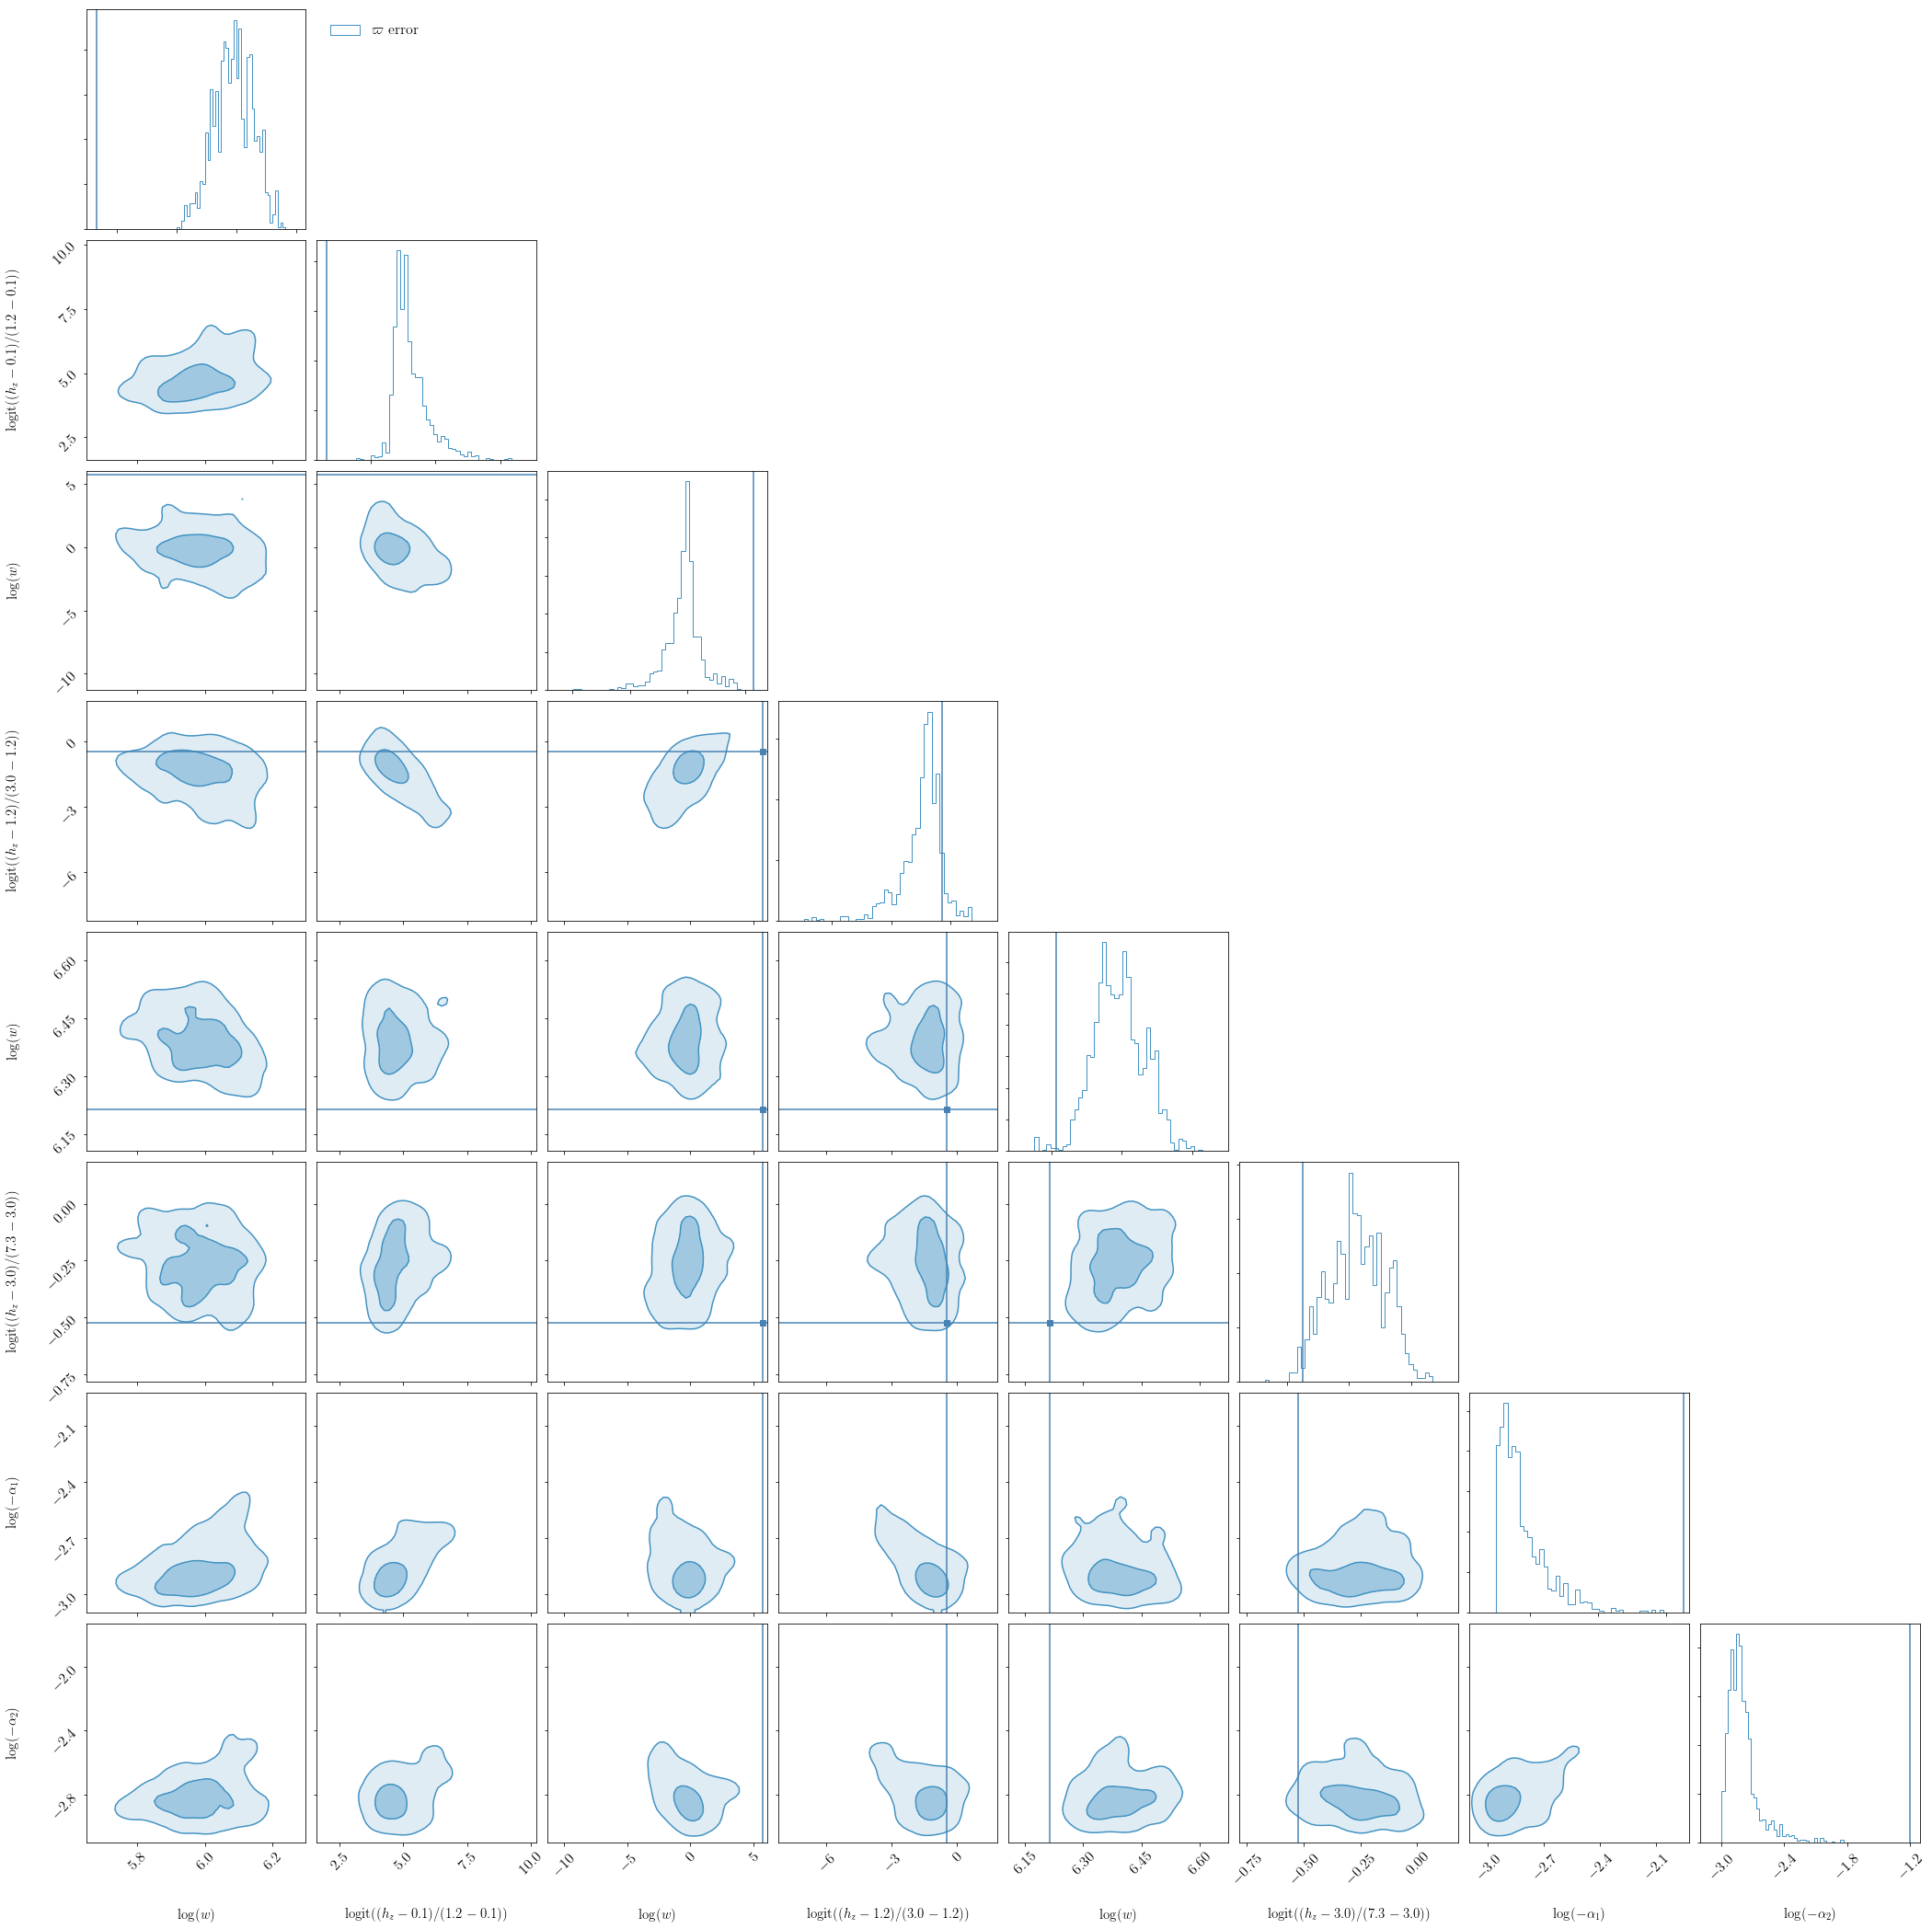

In [142]:
index = [r'$\varpi$ error']
ndim=len(true_params); fig, axes = plt.subplots(ndim,ndim, figsize=(30,30))
plotting.layered_corners([data['chain']['full_perr']], index=index, truths=true_params_f, labels=labels,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2)], fig=fig, ax=axes)

In [1]:
import time

In [7]:
times = []; checkpoints = []
times.append(time.time())
checkpoints.append('start')

In [17]:
times.append(time.time())
checkpoints.append('next~')

In [18]:
times.append(time.time())
checkpoints.append('fin')

In [23]:
[print(f"Time {checkpoints[i+1]}: {(times[i+1]-times[i]):.0f}s") for i in range(len(checkpoints)-1)]

Time next~: 0s
Time fin: 0s
Time next~: 59s
Time fin: 0s


[None, None, None, None]

In [22]:
print(f"Total: {times[-1]-times[0]}")

Total: 59.39314866065979


# Run tests

In [11]:
# Apply Gaia Selection Function
from selectionfunctions.carpentry import chisel
import selectionfunctions.cog_ii as CoGii
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'
#CoGii.fetch()
dr2_sf = CoGii.dr2_sf(version='modelAB',crowding=False)
sample['gaiasf_subset'] = sf_utils.apply_subgaiasf(sample['l'], np.arcsin(sample['sinb']),
                                                sample['m'], dr2_sf=dr2_sf)[0]

config['data_dir'] = '/data/asfe2/Projects/astrometry/StanOutput/'
M = 85; C = 1; j=[-1,0,1,2,3,4]; lengthscale=0.3; nside=32
map_fname = f"chisquare_j{str(j).replace(' ','')}_nside{nside}_M{M}_C1_l0.3_results.h5"
ast_sf = chisel(map_fname=map_fname, nside=64, C=C, M=M, basis_options={'needlet':'chisquare', 'j':j, 'B':2.0, 'p':1.0, 'wavelet_tol':1e-2},
                       spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/')
sample['astsf_subset'] = sf_utils.apply_subgaiasf(sample['l'], np.arcsin(sample['sinb']),
                                                  sample['m'], dr2_sf=dr2_sf, sub_sf=ast_sf)[0]

Loading auxilliary data ...
Loading selection function ...
Creating selection function interpolator...
t = 4.291 s
  auxilliary:   4.288 s
          sf:   0.002 s
interpolator:   0.001 s
Loading auxilliary data ...
Spherical basis file loaded
t = 0.723 s
  auxilliary:   0.045 s
          sf:   0.000 s
interpolator:   0.678 s


In [100]:
model_sf_perr = mwfit(sf_bool=True, perr_bool=True, sub_sf=True)
model_sf_perr.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sf_perr_{run_id:03d}.h')

In [101]:
sample['sf_subset'] = sf_subset.copy()
model_sf_perr._generate_fid_pars(dr2_sf=dr2_sf, sub_sf=ast_sf, _m_grid=np.arange(0., 22.1, 0.1))
model_sf_perr._generate_kwargs()

Getting Selectionfunction pars
Higher Res:
Gaia SF:
Ast SF: (6816, 221)
Got Selectionfunction pars
SF - True, Parallax error - True


KeyError: 'parallax_obs'

In [84]:
model_sf_perr._generate_kwargs()
model_sf_perr.mcmc_prior()

  3%|▎         | 6/200 [00:00<00:03, 59.39it/s]

SF - False, Parallax error - False
{'dropoff': 10000000000.0}


100%|██████████| 200/200 [00:02<00:00, 74.90it/s]


In [120]:
model_sf_perr._generate_kwargs()

SF - True, Parallax error - True


In [47]:
prior = model_sf_perr.transform_params(model_sf_perr.prior_flatchain.T, transform='functions').T
plt.hist(-prior[:,3], bins=50);

In [54]:
model_sf_perr.evaluate_likelihood(model_sf_perr.prior_flatchain[0], grad=True)

(-346481.406204852,
 array([  58688.63011141,   10562.83979039,   21932.51178047,
          -8284.13806623,   76789.94590996,   19696.51589898,
          63625.67137849,    -301.39051713,   64518.44150344,
         -27104.34797055,   56954.68765663,   -4322.83080086,
        -176334.93464441,    6137.19280933]))

In [109]:
model_sf_perr.evaluate_likelihood(true_params_f, grad=True)

(346586.312287678,
 array([ 95.58427325, -53.46755952,  15.3777597 ,  17.3510141 ,
         30.51674059,  -9.03007479,   2.66603683,   2.05993734,
         24.90587168,   4.53545183,   6.25789488,   1.28027494,
        -52.82974559,  34.24980021]))

In [138]:
model_sf_perr.evaluate_likelihood(true_params_f, grad=True)

(346584.5568713549,
 array([ 95.63461232, -53.46193017,  15.32413714,  17.33455365,
         30.45649806,  -9.06346654,   2.66857546,   2.0589742 ,
         24.91577515,   4.5189218 ,   6.25393432,   1.28223964,
        -52.75080648,  34.27575716]))

In [139]:
test_params = model_sf_perr.optimize_results['x']['sf_perr_bfgs'][1].copy()-1e-5
model_sf_perr.evaluate_likelihood(test_params, grad=True)

(346843.4733404452,
 array([-7.59824496e-03,  3.84052428e-02,  2.68635311e-01, -4.47654199e-02,
         1.21003164e-01, -6.15832057e-02, -2.05297972e-02,  2.17242186e-02,
         1.65606258e-01,  1.19245950e-02,  3.11453802e-02,  1.70425659e+03,
         2.13467775e-02,  3.35036146e-02]))

In [140]:
model_sf_perr.evaluate_likelihood(true_params_f, grad=True)

(346595.7754344495,
 array([ 95.19823058, -53.53898081,  15.85424362,  17.44854828,
         30.95750877,  -8.95534996,   2.65329647,   2.06367634,
         24.85114618,   4.60524803,   6.28054712,   1.26568182,
        -53.34681246,  34.0807172 ]))

In [141]:
test_params = model_sf_perr.optimize_results['x']['sf_perr_bfgs'][1].copy()-1e-5
model_sf_perr.evaluate_likelihood(test_params, grad=True)

(346833.32631014363,
 array([ 3.00418059e-01,  3.03966409e-04,  1.70691249e-01, -1.74746548e-02,
         7.96076351e-02, -6.41086405e-02,  1.82818096e-03,  9.77202725e-03,
        -1.01014517e-01,  1.11742853e-02,  2.64800084e-01,  1.70399770e+03,
        -3.33657456e-02,  1.39955068e-01]))

In [142]:
model_sf_perr.evaluate_likelihood(true_params_f, grad=True)

(346596.19759547466,
 array([ 95.16529893, -53.54106464,  15.89667171,  17.4518169 ,
         30.98855575,  -8.96662079,   2.65253673,   2.06405882,
         24.85303085,   4.60676767,   6.28110878,   1.26520344,
        -53.38290947,  34.06890684]))

In [143]:
test_params = model_sf_perr.optimize_results['x']['sf_perr_bfgs'][1].copy()-1e-5
model_sf_perr.evaluate_likelihood(test_params, grad=True)

(346843.8170278846,
 array([-1.32183922e-02,  3.82249569e-02,  2.79111067e-01, -4.69121663e-02,
         1.23165522e-01, -6.18170469e-02, -2.12308818e-02,  2.21446991e-02,
         1.69064048e-01,  1.19435058e-02,  3.66728468e-02,  1.70425317e+03,
         1.02003140e-02,  2.49184509e-02]))

In [148]:
np.sum(model_sf_perr.sample['sf_subset']) * 0.01

432.25

In [128]:
test_params = model_sf_perr.optimize_results['x']['sf_perr_bfgs'][1].copy()-1e-5
test_params[11] = -1.
model_sf_perr.evaluate_likelihood(test_params, grad=True, test=True)

(388791.77552306716,
 -45351.341496435154,
 -36.07485307027721,
 array([ 30920.52321997,  -4219.28098604,  -1936.6292471 ,    388.03395646,
           583.86913321,    -44.31449508,    -52.55228819,     55.88129807,
         11720.60764682,     39.42196791,  -3630.00999676,   1881.70269485,
        -16278.06656232,    351.86978107]),
 array([-2.97506574e+04,  4.13405702e+03,  1.92338909e+03,  7.14521389e-01,
        -7.10185092e+02,  4.38277627e+01,  1.95665726e+02, -1.01232877e+01,
        -1.48904990e+04, -4.75953663e+01,  7.04603610e+03,  5.66956967e+02,
         1.53773558e+04, -3.77841579e+02]),
 array([ 0.16993657, -0.64322941, -0.89837416,  0.        ,  2.86412563,
        -0.70843633, -0.84386462,  0.        , -3.03406219,  0.99661045,
        -0.86655882,  0.        ,  0.        ,  0.        ]))

In [133]:
test_params = model_sf_perr.optimize_results['x']['sf_perr_bfgs'][1].copy()-1e-5
#test_params[12] = -4.5
model_sf_perr.evaluate_likelihood(test_params, grad=True, test=False)

(346835.01838663826,
 array([ 2.18930588e-01,  1.40057824e-02,  1.76814486e-01, -1.89955321e-02,
         8.47713799e-02, -6.33453357e-02, -1.96959342e-03,  1.19378067e-02,
        -2.46907904e-02,  1.13742446e-02,  1.79582733e-01,  1.70402081e+03,
         8.40299376e-03,  1.30167138e-01]))

In [135]:
model_sf_perr.evaluate_likelihood(test_params, grad=True, test=False)

(346803.60353063553,
 array([ 1.74444399e+01, -7.81769559e-01, -2.13950692e+00,  2.25058242e-01,
         6.23558251e-01, -8.59423822e-02, -1.15820189e-01,  1.15263997e-01,
        -1.77889869e+01, -6.22811650e-02,  1.06559407e+01,  1.69859481e+03,
        -1.27217143e+00,  2.76619747e+00]))

In [126]:
test_params = true_params_f.copy()
test_params[11] = -2.
model_sf_perr.evaluate_likelihood(test_params, grad=True, test=True)

(389536.62484506087,
 -43025.812960842435,
 -29.87499341879053,
 array([ 1.95660962e+04, -3.81678507e+03, -1.22298567e+03,  9.39838250e+00,
         1.47944129e+04, -3.26992786e+03, -8.27473616e+01,  2.12417708e+01,
         8.86449088e+03,  2.09380890e+03, -2.18844598e+02,  1.61439229e+02,
        -2.08220324e+04,  3.34904373e+03]),
 array([-1.94082269e+04,  3.77166222e+03,  1.21289815e+03, -1.95718048e-01,
        -1.46903861e+04,  3.25055335e+03,  8.90615100e+01, -2.32430824e+00,
        -8.92719998e+03, -2.07735834e+03,  3.60709061e+02, -1.27314615e+02,
         2.06499160e+04, -3.32787063e+03]),
 array([ 1.2       , -0.45454545, -0.88      ,  0.        ,  0.3       ,
         0.22222222, -0.996     ,  0.        , -1.5       ,  0.63636364,
        -0.99      ,  0.        ,  0.        ,  0.        ]))

In [111]:
model = lambda x: model_sf_perr.evaluate_likelihood(x, grad=False)
scipy.optimize.approx_fprime(model_sf_perr.optimize_results['x']['sf_perr_bfgs'][1]-1e-5, model, 1e-8)

array([ 2.21189093e-01,  1.45519153e-01,  1.74622984e-01,  0.00000000e+00,
        8.73114841e-02, -5.23868951e-02,  0.00000000e+00,  1.16415321e-02,
       -2.91038280e-02,  5.82076613e-03,  1.74622984e-01,  1.70440181e+03,
        6.98491935e-02,  9.89530231e-02])

In [86]:
model_sf_perr.evaluate_likelihood(model_sf_perr.optimize_results['x']['sf_perr_bfgs'][1]-1e-5, grad=True)

(2155566.255070323,
 array([ 1.02825337e+04,  3.68294702e+03, -3.50769681e+02,  2.82630609e+01,
         1.10989417e+03,  3.82264974e+01, -8.73781990e+01,  7.74673198e+01,
        -2.84570146e+04,  3.10976726e+02,  7.41858948e+03, -9.30739356e+02,
        -2.28234955e+03, -1.88879703e+03]))

In [70]:
model_sf_perr.optimize_results['x']['sf_perr_bfgs'][1]

array([11.13103477,  1.52733577,  2.92746528,  0.1442296 ,  8.09471109,
        1.7680854 ,  2.46890554, -0.94174275, 11.88815609, -6.37849978,
        2.638201  ,  3.        , -1.77520952, -0.85812259])

In [67]:
model_sf_perr.optimize_chunk(p0=model_sf_perr.optimize_results['x']['sf_perr_bfgs'][1]-1e-5, method='L-BFGS-B')

SF - False, Parallax error - False
poisson_like(p0): -1.00e+20


IndexError: invalid index to scalar variable.